In [8]:
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
df = spark.read.parquet(bucket_dir + 'VM2Uniform--WY--2021-01-13')


# PSTAT 135 Group Project
# Quality of School District and Voting Outcomes

#### Group 19: Adam Alcala, Yixuan Li, Lex Navarra, Richard Zhao

#### *This segment of the file is from an earlier iteration of our EDA
I wanted to leave this in so that we can get some context as to how the notebook changed over time.

##### Is there a connection between the quality of school district and voter turnout?

Right now, our project is only at the preliminary stage. If we were to use this data, it wouldn't be the most effective at representing the true quality of school districts. The biggest issues currently are to find a better way to represent school district quality, as well as a way to correlate that by county voter turnout. The columns in the data did not seem to be very clear at seperating county turnout with specific voters, so more data exploration is required. However, this was a significant step in finding out how to answer our question, and can even lead us into figuring out more specific relations or examinations.

When beginning further EDA for this assignment, here's how the general idea will go:
1. Load in the dataset for a state
2. Get the data for education level
3. Find out the voter turnout data for a specific election (or multiple)
4. Explore the data using various columns, with education level and voter turnout as the main focus.

## Code for exploring the dataset 
Starting Point for EDA. Thank you to Lex Navarra for providing the template for the code!

## Texas EDA with the 2016 Presidential Election
This notebook is focused on exploring the dataset for Texas

In [1]:
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
df = spark.read.parquet(bucket_dir + 'VM2Uniform--TX--2021-06-12')

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnull, isnan, when, count, col, countDistinct, round,  translate, max, min

In [2]:
#Checking counties in TX:
df.select(['County']).distinct().show()
df.select(['County']).distinct().count()

+------------+
|      County|
+------------+
|     JOHNSON|
|     RANDALL|
|      PARKER|
|       RAINS|
|       TERRY|
|       TITUS|
|       JONES|
|THROCKMORTON|
|       GREGG|
|     KAUFMAN|
|     HASKELL|
|   TOM GREEN|
|        RUSK|
|     COLEMAN|
|   FREESTONE|
|      BLANCO|
|      BORDEN|
|      MEDINA|
|        COKE|
|      DEWITT|
+------------+
only showing top 20 rows



254

There are 254 counties in Texas

These are the variables we would like to keep. These have to do with the voter turnout, education of the voters, and the outcome of the 2016 presidential election

In [3]:
#Continuing with the setup from Assignment 1:
keep = ['LALVOTERID', 'County', 'Board_of_Education_District', 'County_Board_of_Education_District', 'CommercialData_Education',
        'CommercialData_AreaMedianEducationYears', 'CommercialDataLL_Interest_in_Education_Online_In_Household',
        'ElectionReturns_G16_Cnty_Margin_Clinton_D', 'ElectionReturns_G16_Cnty_Percent_Clinton_D', 
        'ElectionReturns_G16_Cnty_Vote_Clinton_D', 'ElectionReturns_G16_Cnty_Margin_Trump_R',
        'ElectionReturns_G16_Cnty_Percent_Trump_R', 'ElectionReturns_G16_Cnty_Vote_Trump_R',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G16CountyTurnoutDemocrats',
        'ElectionReturns_G16CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G16CountyTurnoutRepublicans', 'Parties_Description','VoterParties_Change_Changed_Party']
TX_df = df.select(keep)

### Checking Missing Values in Voter ID and County columns

Number of registered voters in Texas:

In [8]:
total_state_voters_TX = TX_df.select(countDistinct('LALVOTERID'))
total_state_voters_TX.show()

+--------------------------+
|count(DISTINCT LALVOTERID)|
+--------------------------+
|                  15983112|
+--------------------------+



Taking a closer look at the columns, looking at the heatmaps for any missing values

<AxesSubplot:>

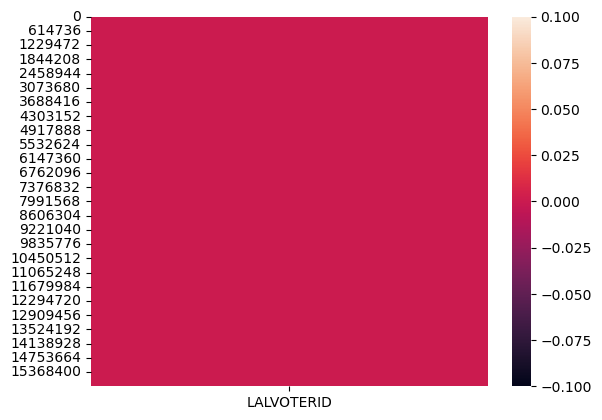

In [7]:
# select TX voter IDs
ID_list = TX_df.select('LALVOTERID')
ID_list_pd = ID_list.toPandas()
# Convert all values to T/F
ID_tf = ID_list_pd.isnull()
# Plot it
sns.heatmap(data=ID_tf)

<AxesSubplot:>

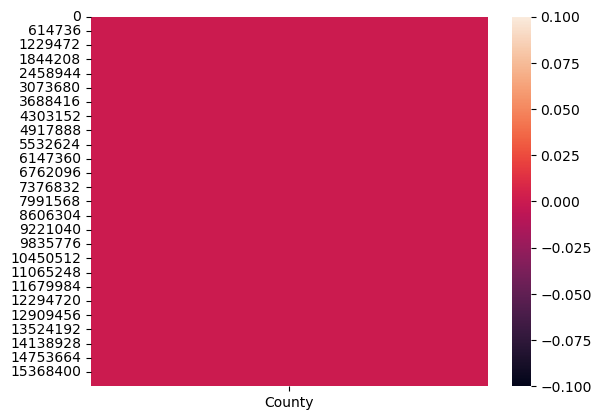

In [8]:
# select TX counties
county_list = TX_df.select('County')
county_list_pd = county_list.toPandas()
# Convert all values to T/F
county_tf = county_list_pd.isnull()
# Plot it
sns.heatmap(data=county_tf)

Heatmaps show no missing data. At least no actual null values.

How many counties are contained in the dataset?

In [6]:
# count number of Counties in Oregon dataset
num_counties_TX = TX_df.select(countDistinct('County'))
num_counties_TX.show()

+----------------------+
|count(DISTINCT County)|
+----------------------+
|                   254|
+----------------------+



There are 254 counties in Texas! We ran the county heatmap above as well, so there's no null values there to worry about.

### Voter turnout in Texas

Now we look more into the dataset. This dataset below shows the columns with the turnout percentages of Democrat, Republican, and Independent voters in each county of Texas. Since there's so many counties in Texas, we will want to focus in on some of the more extreme examples shown in the data.

In [7]:
TX_df = TX_df.withColumnRenamed("ElectionReturns_G16CountyTurnoutAllRegisteredVoters", "CountyTurnoutAll") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutDemocrats", "CountyTurnoutDem") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutIndependentsAllOthers", "CountyTurnoutOther") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutRepublicans", "CountyTurnoutRep")
cty_voter_turnout_TX = TX_df.select('County', 'CountyTurnoutAll', 'CountyTurnoutDem',
                                'CountyTurnoutOther', 'CountyTurnoutRep').distinct().orderBy('County') # unique values per each county
cty_voter_turnout_TX.show()

+---------+----------------+----------------+------------------+----------------+
|   County|CountyTurnoutAll|CountyTurnoutDem|CountyTurnoutOther|CountyTurnoutRep|
+---------+----------------+----------------+------------------+----------------+
| ANDERSON|             60%|             49%|               27%|             77%|
|  ANDREWS|             54%|             27%|               26%|             77%|
| ANGELINA|             58%|             48%|               27%|             75%|
|  ARANSAS|             61%|             51%|               30%|             76%|
|   ARCHER|             68%|             54%|               35%|             77%|
|ARMSTRONG|             73%|             40%|               38%|             80%|
| ATASCOSA|             52%|             53%|               26%|             77%|
|   AUSTIN|             64%|             48%|               32%|             76%|
|   BAILEY|             48%|             26%|               17%|             73%|
|  BANDERA|     

Even looking at the variables we have now, there's already some observations to make. Turnout for counties seems to vary a lot for each county, no matter for which party. The only 'consist' things we can see is that counties seem to rarely (if ever) go above 80 percent turnout. Independent voters are also usually only at about 30 percent turnout. Republican voters in these counties seem the mose consistent, having a turnout usually above 70 percent.

In [8]:
# remove percentages and convert to integer values 
cty_voter_turnout_TX = cty_voter_turnout_TX.withColumn('CountyTurnoutPrcnt', translate(col('CountyTurnoutAll'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntDem', translate(col('CountyTurnoutDem'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntRep', translate(col('CountyTurnoutRep'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntOther', translate(col('CountyTurnoutOther'),'%', ''))\
                    .drop('CountyTurnoutAll', 'CountyTurnoutDem', 'CountyTurnoutRep', 'CountyTurnoutOther')

from pyspark.sql.types import IntegerType
voter_turnout_TX_CLEAN = cty_voter_turnout_TX.withColumn('CountyTurnoutInt', cty_voter_turnout_TX['CountyTurnoutPrcnt'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutDemInt', cty_voter_turnout_TX['CountyTurnoutPrcntDem'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutRepInt', cty_voter_turnout_TX['CountyTurnoutPrcntRep'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutOtherInt', cty_voter_turnout_TX['CountyTurnoutPrcntOther'].cast(IntegerType()))\
                        .drop('CountyTurnoutPrcnt', 'CountyTurnoutPrcntDem', 'CountyTurnoutPrcntRep', 'CountyTurnoutPrcntOther')
voter_turnout_TX_CLEAN.show()

+---------+----------------+-------------------+-------------------+---------------------+
|   County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+---------+----------------+-------------------+-------------------+---------------------+
| ANDERSON|              60|                 49|                 77|                   27|
|  ANDREWS|              54|                 27|                 77|                   26|
| ANGELINA|              58|                 48|                 75|                   27|
|  ARANSAS|              61|                 51|                 76|                   30|
|   ARCHER|              68|                 54|                 77|                   35|
|ARMSTRONG|              73|                 40|                 80|                   38|
| ATASCOSA|              52|                 53|                 77|                   26|
|   AUSTIN|              64|                 48|                 76|                   32|

Next, I want to find the minimum and maximum voter turnouts to see which counties had the highest and lowest in each category.

In [9]:
# find min and max for turnout across all categories
voter_turnout_TX_CLEAN.select(max('CountyTurnoutInt'), max('CountyTurnoutDemInt'), max('CountyTurnoutRepInt'), max('CountyTurnoutOtherInt')).show()
voter_turnout_TX_CLEAN.select(min('CountyTurnoutInt'), min('CountyTurnoutDemInt'), min('CountyTurnoutRepInt'), min('CountyTurnoutOtherInt')).show()
 

+---------------------+------------------------+------------------------+--------------------------+
|max(CountyTurnoutInt)|max(CountyTurnoutDemInt)|max(CountyTurnoutRepInt)|max(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   79|                      74|                      88|                        52|
+---------------------+------------------------+------------------------+--------------------------+



+---------------------+------------------------+------------------------+--------------------------+
|min(CountyTurnoutInt)|min(CountyTurnoutDemInt)|min(CountyTurnoutRepInt)|min(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   37|                      13|                      46|                         6|
+---------------------+------------------------+------------------------+--------------------------+



In [13]:
# find counties w min and max for all turnout
TX_turnout_max_min = voter_turnout_TX_CLEAN.filter((col('CountyTurnoutInt')==79) | (col('CountyTurnoutInt')==37))
TX_turnout_max_min.show()

+---------+----------------+-------------------+-------------------+---------------------+
|   County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+---------+----------------+-------------------+-------------------+---------------------+
|   BORDEN|              79|                 47|                 86|                   27|
|GLASSCOCK|              79|                 30|                 87|                   37|
|     KING|              79|                 51|                 88|                   36|
|    STARR|              37|                 37|                 58|                   14|
+---------+----------------+-------------------+-------------------+---------------------+



The counties with the most turnout were Borden, Glasscock and King, while the county with the least turnout is Starr.

In [14]:
# find counties w min and max for dem turnout
TX_dem_turnout_max_min = voter_turnout_TX_CLEAN.filter((col('CountyTurnoutDemInt')==74) | (col('CountyTurnoutDemInt')==13))
TX_dem_turnout_max_min.show()

+----------+----------------+-------------------+-------------------+---------------------+
|    County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+----------+----------------+-------------------+-------------------+---------------------+
|JEFF DAVIS|              72|                 74|                 84|                   26|
|    REAGAN|              48|                 13|                 61|                   21|
+----------+----------------+-------------------+-------------------+---------------------+



The Counties with the highest Democrat turnout was Jeff Davis at 72%, while the lowest Democrat turnout was Reagan at 48%.

In [15]:
# find counties w min and max for rep turnout
TX_rep_turnout_max_min = voter_turnout_TX_CLEAN.filter((col('CountyTurnoutRepInt')==88) | (col('CountyTurnoutRepInt')==46))
TX_rep_turnout_max_min.show()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
| FOARD|              54|                 63|                 46|                   15|
|  KING|              79|                 51|                 88|                   36|
+------+----------------+-------------------+-------------------+---------------------+



The County with the highest republican turnout is King at 88%. Foard was the lowest at 46%.

In [16]:
# find counties w min and max for other turnout
TX_other_turnout_max_min = voter_turnout_TX_CLEAN.filter((col('CountyTurnoutOtherInt')==52) | (col('CountyTurnoutOtherInt')==6))
TX_other_turnout_max_min.show()

+--------+----------------+-------------------+-------------------+---------------------+
|  County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+--------+----------------+-------------------+-------------------+---------------------+
|  LOVING|              59|                 62|                 78|                    6|
|STERLING|              68|                 37|                 75|                   52|
+--------+----------------+-------------------+-------------------+---------------------+



The county with the highest independent turnout was Sterling at 52%, and the lowest was Loving at 6%

Looking at the results of the 2016 election, Texas was "Red". It's good to see that consistency with the overall result of the state relates to the higher turnout of counties. However, this doesn't mean that higher turnout means the party will win the state. Population differences can also be a huge factor, since although there can be a lot of counties for a certain party, it ultimately comes down to which party has more votes in the state in total.

## Exploring the 2016 general outcome in Texas

We are going to look at the 2016 presidential elections in extra detail. This data shows the columns with the number and proportion of votes for the two candidates, Hillary Clinton (D) and Donald Trump (R) for each county in Texas.

In [12]:
# get election results per county in Oregon
TX_df = TX_df.withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Clinton_D", "Cnty_Percent_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Clinton_D", "Cnty_Vote_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Trump_R", "Cnty_Percent_R") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Trump_R", "Cnty_Vote_R")
election_results_TX = TX_df.select('County',
                                   'Cnty_Percent_D', 
                                   'Cnty_Vote_D',
                                   'Cnty_Percent_R', 
                                   'Cnty_Vote_R').distinct().orderBy('County')
election_results_TX.show()

+---------+--------------+-----------+--------------+-----------+
|   County|Cnty_Percent_D|Cnty_Vote_D|Cnty_Percent_R|Cnty_Vote_R|
+---------+--------------+-----------+--------------+-----------+
| ANDERSON|           20%|       3369|           78%|      13201|
|  ANDREWS|           17%|        836|           79%|       3927|
| ANGELINA|           25%|       7538|           72%|      21668|
|  ARANSAS|           23%|       2465|           74%|       7740|
|   ARCHER|            9%|        394|           88%|       3786|
|ARMSTRONG|            7%|         70|           91%|        924|
| ATASCOSA|           34%|       4651|           63%|       8618|
|   AUSTIN|           19%|       2320|           79%|       9637|
|   BAILEY|           22%|        397|           75%|       1344|
|  BANDERA|           17%|       1726|           80%|       8163|
|  BASTROP|           37%|      10569|           57%|      16328|
|   BAYLOR|           13%|        191|           85%|       1267|
|      BEE

As we start to look at this data there's a big preference for Trump in the counties shown. The only counties in this preview that have a closer ratio between candidates are Bee, Bell, and Bexar. I think most importantly, Bexar is the only county here that has a majority Democrat vote, and it is also the largest county for these 20. This is what I was referring to at the end of the previous segment. Even if it looks like there's a huge number of red counties, how many people does that correlate to?

In [15]:
# remove percentages and convert to integer values 
election_results_TX = election_results_TX.withColumn('Cnty_Prcnt_D', translate(col('Cnty_Percent_D'),'%', ''))\
                    .withColumn('Cnty_Prcnt_R', translate(col('Cnty_Percent_R'),'%', ''))\
                    .drop('Cnty_Percent_D', 'Cnty_Percent_R')

election_results_TX_CLEAN = election_results_TX.withColumn('Cnty_Prcnt_D_Int', election_results_TX['Cnty_Prcnt_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Prcnt_R_Int', election_results_TX['Cnty_Prcnt_R'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_D_Int', election_results_TX['Cnty_Vote_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_R_Int', election_results_TX['Cnty_Vote_R'].cast(IntegerType()))\
                        .drop('Cnty_Prcnt_D', 'Cnty_Prcnt_R', 'Cnty_Vote_D', 'Cnty_Vote_R')
election_results_TX_CLEAN.show()

+---------+----------------+----------------+---------------+---------------+
|   County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+----------------+----------------+---------------+---------------+
| ANDERSON|              20|              78|           3369|          13201|
|  ANDREWS|              17|              79|            836|           3927|
| ANGELINA|              25|              72|           7538|          21668|
|  ARANSAS|              23|              74|           2465|           7740|
|   ARCHER|               9|              88|            394|           3786|
|ARMSTRONG|               7|              91|             70|            924|
| ATASCOSA|              34|              63|           4651|           8618|
|   AUSTIN|              19|              79|           2320|           9637|
|   BAILEY|              22|              75|            397|           1344|
|  BANDERA|              17|              80|           1726|   

In [21]:
from pyspark.sql import functions as F

total_votes = election_results_TX.agg(
    F.sum('Cnty_Vote_D').alias('total_Cnty_Vote_D'),
    F.sum('Cnty_Vote_R').alias('total_Cnty_Vote_R')
)

total_votes.show()

+-----------------+-----------------+
|total_Cnty_Vote_D|total_Cnty_Vote_R|
+-----------------+-----------------+
|        3877868.0|        4685047.0|
+-----------------+-----------------+



Number of counties with majority Democrat (Clinton):

In [16]:
# count how many Oregon counties Clinton got the majority vote in
election_results_TX_CLEAN.filter(col('Cnty_Prcnt_D_Int')>col('Cnty_Prcnt_R_Int')).count()

27

Number of counties with majority Republican (Trump):

In [17]:
# count how many counties Trump got the majority vote in
election_results_TX_CLEAN.filter(col('Cnty_Prcnt_D_Int')<col('Cnty_Prcnt_R_Int')).count()
  

227

There are 27 counties with majority Democrat votes, and 227 counties that had majority Republican vote. That's about a 9 times difference in between candidates. Considering the total amount of votes shown earlier, 3,877,868 Democrat vs 4,685,047 Republican, that shows how the most populated counties and cities probably add the most to the Democrat vote.

Next, lets find the maximum and minimum percentage values for the vote proportions.

In [19]:
# find min and max for percent of votes for democrat and republican
election_results_TX_CLEAN.select(max('Cnty_Prcnt_D_Int'), max('Cnty_Prcnt_R_Int')).show()
election_results_TX_CLEAN.select(min('Cnty_Prcnt_D_Int'), min('Cnty_Prcnt_R_Int')).show()

+---------------------+---------------------+
|max(Cnty_Prcnt_D_Int)|max(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   79|                   95|
+---------------------+---------------------+



+---------------------+---------------------+
|min(Cnty_Prcnt_D_Int)|min(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                    3|                   19|
+---------------------+---------------------+



In [20]:
# find counties w min and max percent of votes for Democrat
TX_D_Prcnt_max_min = election_results_TX_CLEAN.filter((col('Cnty_Prcnt_D_Int')==79) | (col('Cnty_Prcnt_D_Int')==3))
TX_D_Prcnt_max_min.show()
TX_R_Prcnt_max_min = election_results_TX_CLEAN.filter((col('Cnty_Prcnt_R_Int')==95) | (col('Cnty_Prcnt_R_Int')==19))
TX_R_Prcnt_max_min.show()

+------+----------------+----------------+---------------+---------------+
|County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+----------------+----------------+---------------+---------------+
|  KING|               3|              94|              5|            149|
| STARR|              79|              19|           9289|           2224|
+------+----------------+----------------+---------------+---------------+



+-------+----------------+----------------+---------------+---------------+
| County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+-------+----------------+----------------+---------------+---------------+
|ROBERTS|               4|              95|             20|            524|
|  STARR|              79|              19|           9289|           2224|
+-------+----------------+----------------+---------------+---------------+



Surprisingly, the county with the highest percent of democrat percent was Starr, which is a relatively very small county considering the total population of voters. King, an extremely small county with only 154 voters, had the lowest percentage of democrat votes.

Looking at the Republican maximum and minimum, Starr is also here, having the least proportion of republican voters at 19%. The county with the highest proportion of vote percent was Roberts, with 95% of the vote being republican. This town is also very small, with only 544 voters in the dataset.

I was suprised that the minimum and maximum for Democrat voters still came from relatively small cities. Let's see what some of the other top proportions of counties were:


In [26]:
from pyspark.sql.types import DoubleType

from pyspark.sql.types import DoubleType

top_20_dem = election_results_TX.withColumn('Cnty_Prcnt_D', F.col('Cnty_Prcnt_D').cast(DoubleType())) \
                                .orderBy(F.desc('Cnty_Prcnt_D')) \
                                .limit(20)

top_20_rep = election_results_TX.orderBy(F.desc('Cnty_Percent_R')).limit(20)

top_20_dem.show()
top_20_rep.show()

+---------+-----------+-----------+------------+------------+
|   County|Cnty_Vote_D|Cnty_Vote_R|Cnty_Prcnt_D|Cnty_Prcnt_R|
+---------+-----------+-----------+------------+------------+
|    STARR|       9289|       2224|        79.0|          19|
|   ZAVALA|       2636|        694|        78.0|          20|
| JIM HOGG|       1635|        430|        77.0|          20|
| MAVERICK|      10397|       2816|        77.0|          21|
|   BROOKS|       1937|        613|        75.0|          24|
|     WEBB|      42307|      12947|        74.0|          23|
|  EL PASO|     147843|      55512|        69.0|          26|
|  HIDALGO|     118809|      48642|        69.0|          28|
|    DUVAL|       2783|       1316|        67.0|          32|
|   DIMMIT|       2173|        974|        67.0|          30|
|  WILLACY|       3422|       1547|        67.0|          30|
|   TRAVIS|     308260|     127209|        66.0|          27|
|   ZAPATA|       2063|       1029|        66.0|          33|
| PRESID

+------------+-----------+-----------+------------+------------+
|      County|Cnty_Vote_D|Cnty_Vote_R|Cnty_Prcnt_D|Cnty_Prcnt_R|
+------------+-----------+-----------+------------+------------+
|     ROBERTS|         20|        524|           4|          95|
|        KING|          5|        149|           3|          94|
|   GLASSCOCK|         34|        553|           6|          92|
| SHACKELFORD|        103|       1378|           7|          92|
|      MOTLEY|         40|        566|           7|          92|
|    MCMULLEN|         40|        454|           8|          91|
|     WHEELER|        194|       2087|           8|          91|
|   ARMSTRONG|         70|        924|           7|          91|
|      OLDHAM|         78|        850|           8|          90|
|      BORDEN|         31|        330|           8|          90|
|    HANSFORD|        171|       1730|           9|          89|
|      LOVING|          4|         58|           6|          89|
|        JACK|        314

This is what I was looking for. The counties with the highest democrat percentage are much larger than the counties with the highest republican percentage of votes. This trend can explain how the votes came out to be a lot closer than what the counties may show if you are looking at them alone.

### Exploring Median Education Years by County

<AxesSubplot:ylabel='County'>

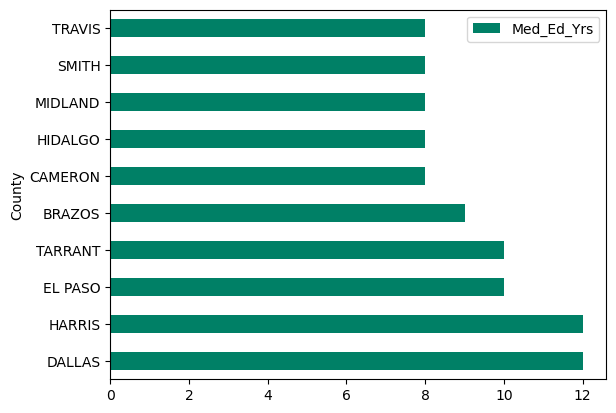

In [22]:
# plot median education years per county using CommercialData_AreaMedianEducationYears
TX_df = TX_df.withColumnRenamed('CommercialData_AreaMedianEducationYears', 'Med_Ed_Yrs')
ed_yrs_by_cty_TX = TX_df.groupBy('County').agg(countDistinct('Med_Ed_Yrs')).orderBy('County')
ed_yrs_by_cty_TX = ed_yrs_by_cty_TX.withColumn('Med_Ed_Yrs', col('count(Med_Ed_Yrs)')).drop(col('count(Med_Ed_Yrs)'))
ed_yrs_by_cty_pd_TX = ed_yrs_by_cty_TX.toPandas()
top_10_ed_yrs = ed_yrs_by_cty_pd_TX.nlargest(10, 'Med_Ed_Yrs')
top_10_ed_yrs.plot.barh(x='County', y='Med_Ed_Yrs', colormap='summer')

In [23]:
# check count of counties for each value of median education years
ed_yrs_by_cty_cnt_TX = ed_yrs_by_cty_TX.groupBy('Med_Ed_Yrs').agg(countDistinct('County')).orderBy('Med_Ed_Yrs')
ed_yrs_by_cty_cnt_TX.show()

+----------+-------------+
|Med_Ed_Yrs|count(County)|
+----------+-------------+
|         0|            2|
|         1|           44|
|         2|           86|
|         3|           56|
|         4|           30|
|         5|           15|
|         6|            5|
|         7|            6|
|         8|            5|
|         9|            1|
|        10|            2|
|        12|            2|
+----------+-------------+



In [24]:
# comparing voter turnout vs. median education years per county
ed_yr_turnout_TX = ed_yrs_by_cty_TX.join(voter_turnout_TX_CLEAN, 'County').orderBy('County').show()

# show voter turnout for counties w maximum median education year and minimum education year
# max_yr_turnout_OR = ed_yr_turnout_OR.where(col('Med_Ed_Yrs') == 7)

+---------+----------+----------------+-------------------+-------------------+---------------------+
|   County|Med_Ed_Yrs|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+---------+----------+----------------+-------------------+-------------------+---------------------+
| ANDERSON|         3|              60|                 49|                 77|                   27|
|  ANDREWS|         4|              54|                 27|                 77|                   26|
| ANGELINA|         4|              58|                 48|                 75|                   27|
|  ARANSAS|         4|              61|                 51|                 76|                   30|
|   ARCHER|         2|              68|                 54|                 77|                   35|
|ARMSTRONG|         2|              73|                 40|                 80|                   38|
| ATASCOSA|         3|              52|                 53|                 77|   

### Exploring Education Level by County

Creating new 'Education_Lvl' variable:

In [5]:
## clean education level column
ed_lvl_combine = when(TX_df.CommercialData_Education.like('Grad Degree%'), 'Grad Degree')\
                .when(TX_df.CommercialData_Education.like('Bach Degree%'), 'Bach Degree')\
                .when(TX_df.CommercialData_Education.like('Vocational Technical Degree%'), 'Vocational Technical Degree')\
                .when(TX_df.CommercialData_Education.like('Some College%'), 'Some College')\
                .when(TX_df.CommercialData_Education.like('HS Diploma%'), 'HS Diploma')\
                .when(TX_df.CommercialData_Education.like('Less than HS Diploma%'), 'Less Than HS Diploma')\
                .otherwise('Null')
TX_df = TX_df.withColumn("Education_Lvl", ed_lvl_combine)

In [6]:
## find counts and proportions of each level of education for the state of Texas
from pyspark.sql.functions import col, countDistinct, round, when

total_state_voters = TX_df.select('LALVOTERID').count()
print('The total number of voters in the state of Texas:', total_state_voters)

ed_lvl_st_cnt = TX_df.groupBy(['Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_st_cnt = ed_lvl_st_cnt.withColumnRenamed('count(LALVOTERID)', 'num_voters')
ed_lvl_state = ed_lvl_st_cnt.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters)*100), 2))
ed_lvl_state.show()

The total number of voters in the state of Texas: 15983112


+--------------------+----------+--------------+
|       Education_Lvl|num_voters|prcnt_of_total|
+--------------------+----------+--------------+
|Less Than HS Diploma|    625944|          3.92|
|          HS Diploma|   2502788|         15.66|
|         Bach Degree|   2889303|         18.08|
|         Grad Degree|   1407284|           8.8|
|Vocational Techni...|     16076|           0.1|
|        Some College|   2455898|         15.37|
|                Null|   6085819|         38.08|
+--------------------+----------+--------------+



<AxesSubplot:ylabel='Education_Lvl'>

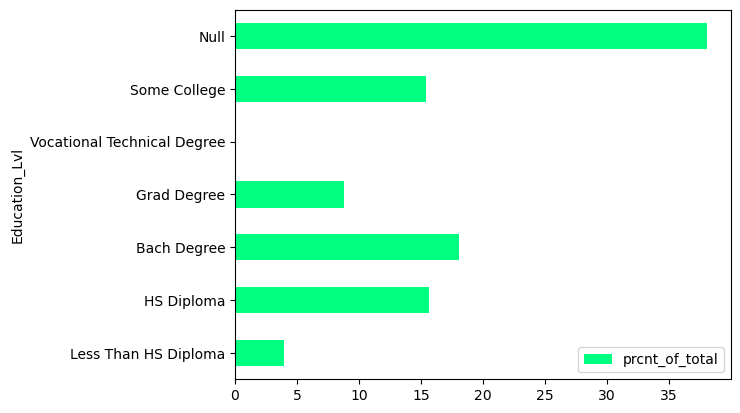

In [12]:
## visualize above
ed_lvl_state_pd = ed_lvl_state.toPandas()
ed_lvl_state_pd.plot(kind='barh', x='Education_Lvl', y='prcnt_of_total', colormap='winter_r')


Distribution of education level in voters across different counties in the state of Wyoming:

In [7]:
## find counts and proportions of each level of education for each county in the state of Texas
from pyspark.sql.functions import col, countDistinct, round

county_voters = TX_df.groupBy('County').agg(countDistinct('LALVOTERID'))
county_voters = county_voters.withColumn("voter_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 

ed_lvl_county_cnt = TX_df.groupBy(['County','Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_county_cnt = ed_lvl_county_cnt.withColumn("ed_level_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 
ed_lvl_by_county = ed_lvl_county_cnt.join(county_voters, 'County').orderBy('County')
ed_lvl_by_county = ed_lvl_by_county.withColumn("prcnt_of_total", round(((col("ed_level_total")/col("voter_total"))*100), 2))
ed_lvl_by_county.show()

+--------+--------------------+--------------+-----------+--------------+
|  County|       Education_Lvl|ed_level_total|voter_total|prcnt_of_total|
+--------+--------------------+--------------+-----------+--------------+
|ANDERSON|Vocational Techni...|            40|      27566|          0.15|
|ANDERSON|         Grad Degree|          1358|      27566|          4.93|
|ANDERSON|          HS Diploma|          6516|      27566|         23.64|
|ANDERSON|        Some College|          4205|      27566|         15.25|
|ANDERSON|Less Than HS Diploma|          1249|      27566|          4.53|
|ANDERSON|         Bach Degree|          3408|      27566|         12.36|
|ANDERSON|                Null|         10790|      27566|         39.14|
| ANDREWS|        Some College|          1630|       9316|          17.5|
| ANDREWS|Less Than HS Diploma|           689|       9316|           7.4|
| ANDREWS|         Grad Degree|           359|       9316|          3.85|
| ANDREWS|                Null|       

Visualization of the distribution of education level across each Texas county:

<AxesSubplot:title={'center':'Null Values'}, ylabel='County'>

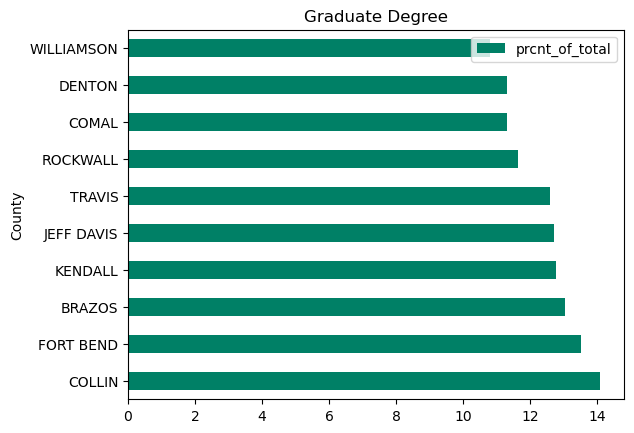

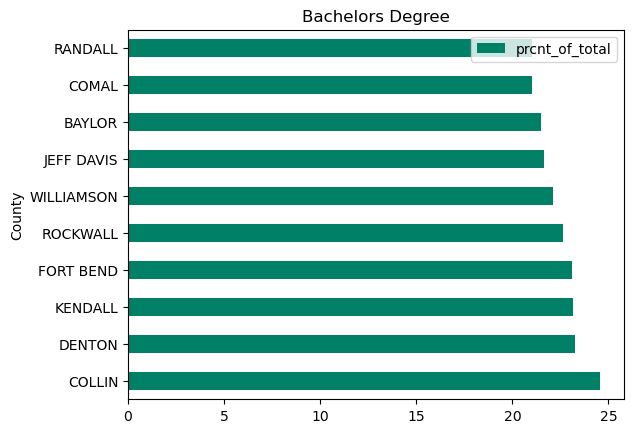

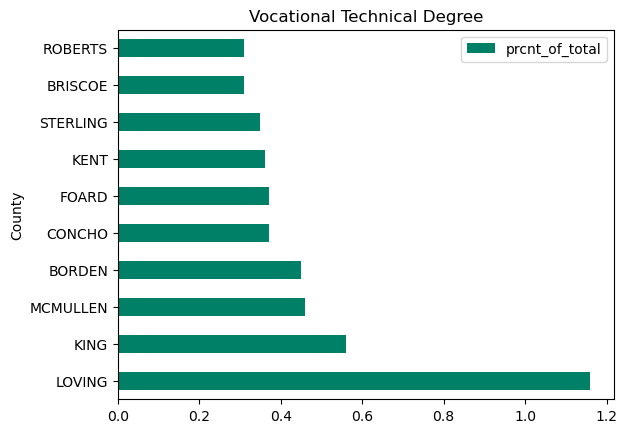

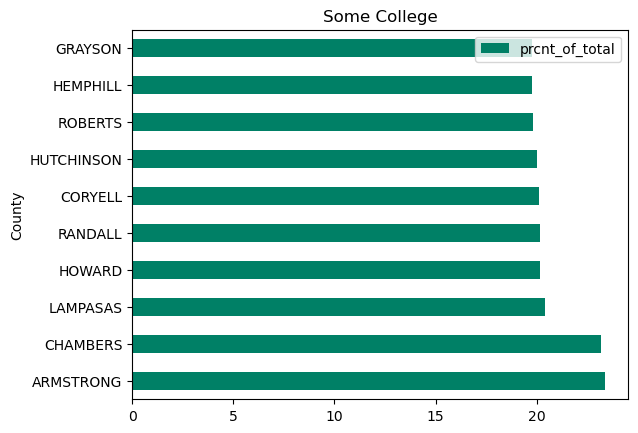

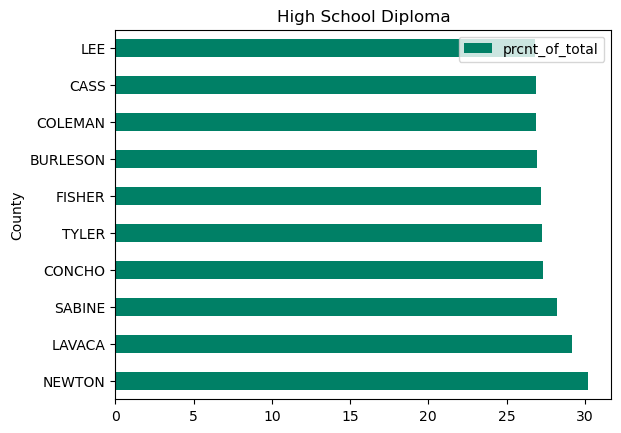

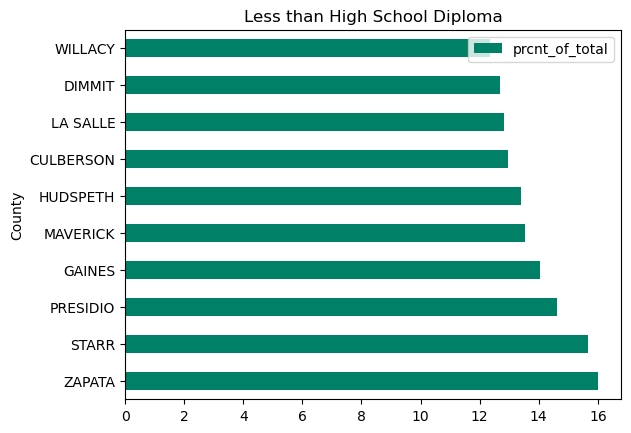

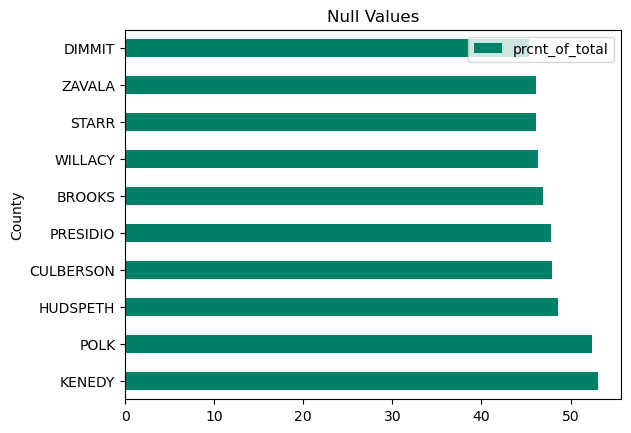

In [8]:
## visualize above

## distribution of grad degrees per county
grad_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Grad Degree")
grad_dgs_by_county_pd = grad_dgs_by_county.toPandas()
top_10_grad_dgs = grad_dgs_by_county_pd.nlargest(10, 'prcnt_of_total')
top_10_grad_dgs.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Graduate Degree')

## distribution of bach degrees per county
bach_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Bach Degree")
bach_dgs_by_county_pd = bach_dgs_by_county.toPandas()
top_10_bach_dgs = bach_dgs_by_county_pd.nlargest(10, 'prcnt_of_total')
top_10_bach_dgs.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Bachelors Degree')

## distribution of vocational technical degrees per county
voc_dgs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Vocational Technical Degree")
voc_dgs_by_county_pd = voc_dgs_by_county.toPandas()
top_10_voc_dgs = voc_dgs_by_county_pd.nlargest(10, 'prcnt_of_total')
top_10_voc_dgs.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Vocational Technical Degree')

## distribution of some college per county
some_col_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Some College")
some_col_by_county_pd = some_col_by_county.toPandas()
top_10_some_col_dgs = some_col_by_county_pd.nlargest(10, 'prcnt_of_total')
top_10_some_col_dgs.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Some College')

## distribution of hs diploma per county
hs_dip_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "HS Diploma")
hs_dip_by_county_pd = hs_dip_by_county.toPandas()
top_10_hs_dip_dgs = hs_dip_by_county_pd.nlargest(10, 'prcnt_of_total')
top_10_hs_dip_dgs.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='High School Diploma')

## distribution of less than hs diploma per county
less_thn_hs_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Less Than HS Diploma")
less_thn_hs_by_county_pd = less_thn_hs_by_county.toPandas()
top_10_less_thn_hs_dgs = less_thn_hs_by_county_pd.nlargest(10, 'prcnt_of_total')
top_10_less_thn_hs_dgs.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Less than High School Diploma')

## distribution of null education level per county
null_ed_lvl_by_county = ed_lvl_by_county.filter(ed_lvl_by_county.Education_Lvl == "Null")
null_ed_lvl_by_county_pd = null_ed_lvl_by_county.toPandas()
top_10_null_ed_dgs = null_ed_lvl_by_county_pd.nlargest(10, 'prcnt_of_total')
top_10_null_ed_dgs.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Null Values')

In [9]:
df.select(['Parties_Description']).distinct().show()

+-------------------+
|Parties_Description|
+-------------------+
|         Republican|
|         Democratic|
|       Non-Partisan|
+-------------------+



In [10]:
df.select(['VoterParties_Change_Changed_Party']).distinct().show()

+---------------------------------+
|VoterParties_Change_Changed_Party|
+---------------------------------+
|                             null|
|               Within Last 1 Year|
|             Between 2 and 4 Y...|
|             Between 1 and 2 Y...|
+---------------------------------+



In [12]:
party_st_cnt = TX_df.groupBy(['Parties_Description']).agg(countDistinct('LALVOTERID'))
party_st_cnt = party_st_cnt.withColumnRenamed('count(LALVOTERID)', 'num_voters')
party_state = party_st_cnt.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters)*100), 2))
party_state.show()

+-------------------+----------+--------------+
|Parties_Description|num_voters|prcnt_of_total|
+-------------------+----------+--------------+
|         Republican|   5905292|         36.95|
|         Democratic|   7601078|         47.56|
|       Non-Partisan|   2476742|          15.5|
+-------------------+----------+--------------+



### More Code